In [5]:
"""
LIME Stability Analysis for Text Classification
================================================
Team: ModelMiners (Abdul Aahad Qureshi, Khyzer Baig)
Project: iML Winter 2025/26

Research Question: How stable are LIME explanations for text classification?
"""

# Check Python version
import sys
print(f"Python version: {sys.version}")
print(f"Running on: Colab")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Running on: Colab


In [6]:
# Restart runtime after this
!pip install transformers==4.36.0 huggingface_hub==0.20.0

  Using cached huggingface_hub-0.20.0-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.20.0-py3-none-any.whl (329 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface_hub 1.3.3
    Uninstalling huggingface_hub-1.3.3:
      Successfully uninstalled huggingface_hub-1.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.18.0 requires fsspec[http]<=2024.2.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.20.0 which is incompatible.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.20.0 which is incompatible.
accelerate 1.12.0 requires huggingface_hub

In [7]:
%%capture
# Install required packages (suppress output)
!pip install lime==0.2.0.1
!pip install seaborn==0.12.2

# Install datasets at the desired stable version.
# Then, upgrade huggingface_hub and fsspec to ensure compatibility with transformers
# datasets==2.18.0 requires huggingface-hub>=0.14.0,<1.0, so an upgraded version will still be compatible.
!pip install datasets==2.18.0
!pip install --upgrade huggingface_hub
!pip install --upgrade fsspec

print("✅ All packages installed!")

In [8]:
"""
# LIME Stability Analysis for Text Classification

**Team:** ModelMiners (Abdul Aahad Qureshi, Khyzer Baig)
**Course:** Interpretable Machine Learning (iML) Winter 2025/26
**Supervisor:** Lukas Fehring

---

## 1. Introduction & Motivation

LIME (Local Interpretable Model-agnostic Explanations) is one of the most widely-used methods for explaining black-box model predictions. However, it suffers from a critical flaw: **explanation instability due to random sampling**. Running LIME twice on the same input can yield different "important features," undermining trust in high-stakes applications like medical diagnosis or loan decisions.

**Research Question:** How stable are LIME explanations for text classification, and what factors affect this stability?

---

## 2. Related Work

Our work builds on several key papers analyzing explainability method robustness:

| Paper | Key Finding | Gap We Address |
|-------|-------------|----------------|
| **Ribeiro et al. (2016)** - "Why Should I Trust You?" | Introduced LIME | No stability analysis provided |
| **Alvarez-Melis & Jaakkola (2018)** - "On the Robustness of Interpretability Methods" | First systematic stability analysis | Limited text classification focus |
| **Slack et al. (2020)** - "Fooling LIME and SHAP" | Showed adversarial vulnerabilities | Focused on adversarial attacks, not hyperparameter sensitivity |
| **Molnar et al. (2020)** - "Interpretable Machine Learning" | Comprehensive XAI overview | No systematic num_samples analysis |
| **Krishna et al. (2022)** - "The Disagreement Problem in Explainable ML" | Showed explanation disagreement across methods | Cross-method focus, not within-method stability |

**Our Contribution:** We provide the first systematic analysis of how LIME's `num_samples` parameter affects explanation stability specifically for text classification, along with analysis of sentence length and model complexity effects.

---

## 3. LIME Methodology for Text

### 3.1 How LIME Works

LIME explains predictions by fitting an interpretable surrogate model locally around a specific instance:

1. **Original Prediction:** Get the black-box model's prediction for input text
2. **Perturbation Generation:** Create neighborhood samples by randomly masking words
3. **Surrogate Fitting:** Fit a Ridge Regression model on perturbations weighted by proximity
4. **Explanation:** Extract feature (word) importance coefficients from surrogate

### 3.2 Technical Implementation

```
Surrogate Model: Ridge Regression (L2-regularized linear model)
Text Representation: Bag-of-Words (binary word presence)
Perturbation Method: Random word masking (each word removed with probability p)
Similarity Kernel: Exponential kernel based on cosine distance
```

### 3.3 Why Instability Occurs

LIME's randomness comes from perturbation sampling:
- For a sentence with n words, there are 2^n possible perturbations
- LIME samples only `num_samples` of these (default: 5000)
- Different random samples → Different surrogate models → Different explanations

**Our Hypothesis:** Longer sentences have exponentially larger perturbation spaces (2^n), potentially causing greater instability with fixed sampling.

---

## 4. Experimental Setup

### 4.1 Dataset
- **SST-2** (Stanford Sentiment Treebank): Binary sentiment classification
- ~67,000 training samples, 872 validation samples

### 4.2 Models Tested
| Model | Type | Parameters | Purpose |
|-------|------|------------|---------|
| Logistic Regression + TF-IDF | Simple, linear | ~10K | Baseline |
| DistilBERT (fine-tuned) | Complex, transformer | ~66M | Real-world comparison |

### 4.3 Stability Metrics

| Metric | Description | Ideal Value |
|--------|-------------|-------------|
| **Top-K Agreement** | % overlap in top-3 important words across runs | 1.0 (perfect) |
| **Rank Correlation** | Spearman correlation of word rankings across runs | 1.0 (perfect) |
| **Coefficient of Variation** | Std/Mean of importance scores per word | 0.0 (no variation) |

### 4.4 Reproducibility
- **Seeds:** 5 random seeds (42, 123, 456, 789, 1000)
- **LIME Runs:** 30 runs per sentence
- **Results:** Reported as mean ± std across seeds

---
"""

'\n# LIME Stability Analysis for Text Classification\n\n**Team:** ModelMiners (Abdul Aahad Qureshi, Khyzer Baig)  \n**Course:** Interpretable Machine Learning (iML) Winter 2025/26  \n**Supervisor:** Lukas Fehring\n\n---\n\n## 1. Introduction & Motivation\n\nLIME (Local Interpretable Model-agnostic Explanations) is one of the most widely-used methods for explaining black-box model predictions. However, it suffers from a critical flaw: **explanation instability due to random sampling**. Running LIME twice on the same input can yield different "important features," undermining trust in high-stakes applications like medical diagnosis or loan decisions.\n\n**Research Question:** How stable are LIME explanations for text classification, and what factors affect this stability?\n\n---\n\n## 2. Related Work\n\nOur work builds on several key papers analyzing explainability method robustness:\n\n| Paper | Key Finding | Gap We Address |\n|-------|-------------|----------------|\n| **Ribeiro et al.

In [9]:
# Standard libraries
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Explainability
from lime.lime_text import LimeTextExplainer

# Dataset
from datasets import load_dataset

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# This cell's content is now handled in hteG-FUB-tjM for better dependency management.
# It is left empty or can be removed if desired.


In [10]:
print(" Downloading SST-2 dataset...")

# Load SST-2 from Hugging Face
dataset = load_dataset("glue", "sst2")

print(f" Dataset loaded!")
print(f"   Train samples: {len(dataset['train'])}")
print(f"   Test samples: {len(dataset['validation'])}")

# Convert to DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['validation'])

print(f"\n First 3 test samples:")
for idx, row in test_df.head(3).iterrows():
    label = "POSITIVE" if row['label'] == 1 else "NEGATIVE"
    print(f"{label:10} | {row['sentence']}")

# Add sentence length
test_df['length'] = test_df['sentence'].str.split().str.len()

print(f"\n Sentence length statistics:")
print(test_df['length'].describe())

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

 Dataset loaded!
   Train samples: 67349
   Test samples: 872

 First 3 test samples:
POSITIVE   | it 's a charming and often affecting journey . 
NEGATIVE   | unflinchingly bleak and desperate 
POSITIVE   | allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 

 Sentence length statistics:
count    872.000000
mean      19.548165
std        8.763900
min        2.000000
25%       13.000000
50%       19.000000
75%       26.000000
max       47.000000
Name: length, dtype: float64


In [11]:
class SimpleLogisticModel:
    """Logistic Regression with TF-IDF for sentiment analysis"""

    def __init__(self, seed=42):
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        self.model = LogisticRegression(random_state=seed, max_iter=1000)
        self.is_trained = False

    def fit(self, texts, labels):
        print(" Vectorizing text...")
        X = self.vectorizer.fit_transform(texts)
        print(f" Feature matrix: {X.shape}")

        print(" Training model...")
        self.model.fit(X, labels)
        self.is_trained = True

        train_acc = accuracy_score(labels, self.model.predict(X))
        print(f" Training accuracy: {train_acc:.3f}")

    def predict_proba(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        X = self.vectorizer.transform(texts)
        return self.model.predict_proba(X)

# Train the model
print(" Training Sentiment Classifier\n")
model = SimpleLogisticModel(seed=42)
model.fit(train_df['sentence'].tolist(), train_df['label'].tolist())

# Test accuracy
print("\n Evaluating on test set...")
test_preds = model.predict_proba(test_df['sentence'].tolist())
test_acc = accuracy_score(test_df['label'].tolist(),
                          (test_preds[:, 1] > 0.5).astype(int))
print(f" Test accuracy: {test_acc:.3f}")

 Training Sentiment Classifier

 Vectorizing text...
 Feature matrix: (67349, 5000)
 Training model...
 Training accuracy: 0.868

 Evaluating on test set...
 Test accuracy: 0.802


In [12]:
class LIMEStabilityAnalyzer:
    """Analyze LIME explanation stability"""

    def __init__(self, model):
        self.model = model
        self.explainer = LimeTextExplainer(class_names=['negative', 'positive'])

    def explain_once(self, text, num_samples=1000):
        """Get single LIME explanation"""
        exp = self.explainer.explain_instance(
            text,
            self.model.predict_proba,
            num_features=10,
            num_samples=num_samples
        )
        return dict(exp.as_list())

    def explain_multiple(self, text, num_samples=1000, num_runs=30):
        """Run LIME multiple times"""
        explanations = []
        for _ in range(num_runs):
            exp = self.explain_once(text, num_samples)
            explanations.append(exp)
        return explanations

    def get_top_k(self, explanation, k=3):
        """Get top-k important words"""
        sorted_words = sorted(explanation.items(),
                             key=lambda x: abs(x[1]),
                             reverse=True)
        return [word for word, _ in sorted_words[:k]]

    def visualize_explanation(self, explanation, title="LIME Explanation"):
        """Plot word importances"""
        sorted_items = sorted(explanation.items(),
                             key=lambda x: abs(x[1]),
                             reverse=True)[:10]
        words, scores = zip(*sorted_items)

        colors = ['red' if s < 0 else 'green' for s in scores]

        plt.figure(figsize=(10, 6))
        plt.barh(words, scores, color=colors, alpha=0.7)
        plt.xlabel('Importance Score')
        plt.title(title)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        plt.tight_layout()
        plt.show()

# Create analyzer
analyzer = LIMEStabilityAnalyzer(model)
print(" LIME Analyzer ready!")

 LIME Analyzer ready!


 Test sentence: 'This movie was absolutely terrible and boring'

 Model prediction:
   NEGATIVE (confidence: 0.877)

 Running LIME...


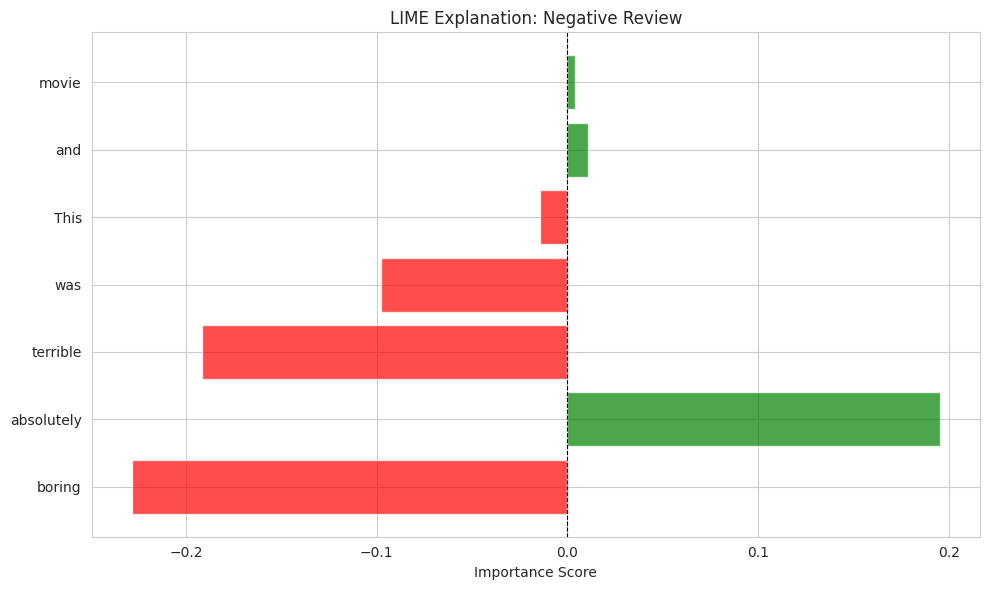


 Top 5 important words:
   boring          -0.228  → Negative
   absolutely      +0.195  → Positive
   terrible        -0.192  → Negative
   was             -0.098  → Negative
   This            -0.014  → Negative


In [13]:
# Test on example sentence
test_sentence = "This movie was absolutely terrible and boring"

print(f" Test sentence: '{test_sentence}'")
print(f"\n Model prediction:")
prob = model.predict_proba([test_sentence])[0]
pred = "POSITIVE" if prob[1] > 0.5 else "NEGATIVE"
print(f"   {pred} (confidence: {max(prob):.3f})")

print(f"\n Running LIME...")
explanation = analyzer.explain_once(test_sentence, num_samples=1000)

# Visualize
analyzer.visualize_explanation(explanation,
                               title="LIME Explanation: Negative Review")

# Show top words
print(f"\n Top 5 important words:")
sorted_exp = sorted(explanation.items(), key=lambda x: abs(x[1]), reverse=True)
for word, score in sorted_exp[:5]:
    direction = "→ Negative" if score < 0 else "→ Positive"
    print(f"   {word:15} {score:+.3f}  {direction}")

In [14]:
class StabilityMetrics:
    """Calculate stability metrics for LIME explanations"""

    @staticmethod
    def top_k_agreement(explanations, k=3):
        """What % of top-k words overlap across runs?"""
        top_k_lists = []
        for exp in explanations:
            sorted_words = sorted(exp.items(),
                                 key=lambda x: abs(x[1]),
                                 reverse=True)
            top_k_lists.append(set([w for w, _ in sorted_words[:k]]))

        # Pairwise overlap
        agreements = []
        n = len(top_k_lists)
        for i in range(n):
            for j in range(i+1, n):
                overlap = len(top_k_lists[i] & top_k_lists[j]) / k
                agreements.append(overlap)

        return np.mean(agreements) if agreements else 0.0

    @staticmethod
    def rank_correlation(explanations):
        """Average Spearman correlation of word rankings"""
        # Get all unique words
        all_words = set()
        for exp in explanations:
            all_words.update(exp.keys())
        all_words = sorted(list(all_words))

        # Create rank vectors
        rank_vectors = []
        for exp in explanations:
            ranks = []
            sorted_words = sorted(exp.items(),
                                 key=lambda x: abs(x[1]),
                                 reverse=True)
            word_to_rank = {w: i for i, (w, _) in enumerate(sorted_words)}

            for word in all_words:
                ranks.append(word_to_rank.get(word, len(sorted_words)))
            rank_vectors.append(ranks)

        # Pairwise correlations
        correlations = []
        n = len(rank_vectors)
        for i in range(n):
            for j in range(i+1, n):
                corr, _ = spearmanr(rank_vectors[i], rank_vectors[j])
                if not np.isnan(corr):
                    correlations.append(corr)

        return np.mean(correlations) if correlations else 0.0

    @staticmethod
    def coefficient_of_variation(explanations):
        """How much do importance scores vary?"""
        all_words = set()
        for exp in explanations:
            all_words.update(exp.keys())

        cvs = []
        for word in all_words:
            scores = [exp.get(word, 0) for exp in explanations]
            mean_abs = np.mean(np.abs(scores))
            std = np.std(scores)

            if mean_abs > 0:
                cvs.append(std / mean_abs)

        return np.mean(cvs) if cvs else 0.0

metrics_calc = StabilityMetrics()
print("✅ Stability metrics ready!")

✅ Stability metrics ready!


In [15]:
"""
## 5. Experiment 1: Effect of num_samples on Stability

**Research Question:** How many perturbation samples does LIME need for stable explanations?

**Hypothesis:** More samples → More stable explanations (but diminishing returns)

**Setup:**
- 50 sentences from SST-2 test set
- num_samples ∈ {100, 250, 500, 1000, 2000}
- 30 LIME runs per sentence × 5 seeds = 150 total runs per sentence

"""

'\n## 5. Experiment 1: Effect of num_samples on Stability\n\n**Research Question:** How many perturbation samples does LIME need for stable explanations?\n\n**Hypothesis:** More samples → More stable explanations (but diminishing returns)\n\n**Setup:**\n- 50 sentences from SST-2 test set\n- num_samples ∈ {100, 250, 500, 1000, 2000}\n- 30 LIME runs per sentence × 5 seeds = 150 total runs per sentence\n\n'

In [16]:

SEEDS = [42, 123, 456, 789, 1000]  # 5 seeds as proposed

# =============================================================================
# EXPERIMENT 1: How does num_samples affect stability?
# Proposal: 50 sentences, num_samples ∈ {100, 250, 500, 1000, 2000}, 30 runs
# =============================================================================

print("="*70)
print("🔬 EXPERIMENT 1: How does num_samples affect stability?")
print("="*70)
print(f"📋 Settings: 50 sentences | 5 seeds | 30 LIME runs per sentence")
print("="*70)

# Settings (matching proposal)
num_samples_list = [100, 250, 500, 1000, 2000]
n_sentences = 50      # Proposal: 50 sentences
n_runs = 30           # Proposal: 30 runs

exp1_all_seeds = []

for seed in SEEDS:
    print(f"\n{'='*70}")
    print(f"🌱 Running with SEED = {seed}")
    print(f"{'='*70}")

    np.random.seed(seed)

    # Get sample sentences for this seed
    sample_sentences = test_df.sample(n=n_sentences, random_state=seed)

    seed_results = []

    for num_samples in tqdm(num_samples_list, desc=f"num_samples (seed={seed})"):
        print(f"\n  Testing num_samples = {num_samples}")

        top3_list = []
        corr_list = []
        cv_list = []

        for idx, row in tqdm(sample_sentences.iterrows(),
                             total=len(sample_sentences),
                             desc=f"Sentences", leave=False):
            text = row['sentence']

            # Run LIME multiple times
            explanations = analyzer.explain_multiple(text,
                                                     num_samples=num_samples,
                                                     num_runs=n_runs)

            # Calculate metrics
            top3 = metrics_calc.top_k_agreement(explanations, k=3)
            corr = metrics_calc.rank_correlation(explanations)
            cv = metrics_calc.coefficient_of_variation(explanations)

            top3_list.append(top3)
            corr_list.append(corr)
            cv_list.append(cv)

        seed_results.append({
            'seed': seed,
            'num_samples': num_samples,
            'top3_agreement': np.mean(top3_list),
            'rank_correlation': np.mean(corr_list),
            'coeff_variation': np.mean(cv_list)
        })

        print(f"    Top-3: {np.mean(top3_list):.3f} | Corr: {np.mean(corr_list):.3f} | CV: {np.mean(cv_list):.3f}")

    exp1_all_seeds.extend(seed_results)

# Convert to DataFrame and aggregate across seeds
exp1_raw_df = pd.DataFrame(exp1_all_seeds)

# Average across seeds
exp1_results = exp1_raw_df.groupby('num_samples').agg({
    'top3_agreement': ['mean', 'std'],
    'rank_correlation': ['mean', 'std'],
    'coeff_variation': ['mean', 'std']
}).reset_index()

# Flatten column names
exp1_results.columns = ['num_samples',
                        'top3_mean', 'top3_std',
                        'corr_mean', 'corr_std',
                        'cv_mean', 'cv_std']

print(f"\n{'='*70}")
print("📊 EXPERIMENT 1 RESULTS (Averaged across 5 seeds):")
print(f"{'='*70}")
print(exp1_results.to_string(index=False))

# Save results
exp1_raw_df.to_csv('exp1_raw_results.csv', index=False)
exp1_results.to_csv('exp1_aggregated_results.csv', index=False)
print("\n✅ Results saved!")

🔬 EXPERIMENT 1: How does num_samples affect stability?
📋 Settings: 50 sentences | 5 seeds | 30 LIME runs per sentence

🌱 Running with SEED = 42


num_samples (seed=42):   0%|          | 0/5 [00:00<?, ?it/s]


  Testing num_samples = 100


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.835 | Corr: 0.804 | CV: 1.117

  Testing num_samples = 250


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.901 | Corr: 0.877 | CV: 0.828

  Testing num_samples = 500


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.916 | Corr: 0.911 | CV: 0.700

  Testing num_samples = 1000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.940 | Corr: 0.935 | CV: 0.584

  Testing num_samples = 2000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.954 | Corr: 0.952 | CV: 0.553

🌱 Running with SEED = 123


num_samples (seed=123):   0%|          | 0/5 [00:00<?, ?it/s]


  Testing num_samples = 100


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.849 | Corr: 0.810 | CV: 1.102

  Testing num_samples = 250


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.906 | Corr: 0.887 | CV: 0.905

  Testing num_samples = 500


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.939 | Corr: 0.913 | CV: 0.715

  Testing num_samples = 1000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.958 | Corr: 0.935 | CV: 0.608

  Testing num_samples = 2000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.967 | Corr: 0.949 | CV: 0.503

🌱 Running with SEED = 456


num_samples (seed=456):   0%|          | 0/5 [00:00<?, ?it/s]


  Testing num_samples = 100


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.877 | Corr: 0.816 | CV: 1.097

  Testing num_samples = 250


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.924 | Corr: 0.893 | CV: 0.830

  Testing num_samples = 500


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.951 | Corr: 0.929 | CV: 0.643

  Testing num_samples = 1000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.961 | Corr: 0.944 | CV: 0.462

  Testing num_samples = 2000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.973 | Corr: 0.960 | CV: 0.384

🌱 Running with SEED = 789


num_samples (seed=789):   0%|          | 0/5 [00:00<?, ?it/s]


  Testing num_samples = 100


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.879 | Corr: 0.820 | CV: 1.148

  Testing num_samples = 250


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.918 | Corr: 0.900 | CV: 0.908

  Testing num_samples = 500


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.939 | Corr: 0.927 | CV: 0.685

  Testing num_samples = 1000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.954 | Corr: 0.948 | CV: 0.591

  Testing num_samples = 2000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.969 | Corr: 0.961 | CV: 0.456

🌱 Running with SEED = 1000


num_samples (seed=1000):   0%|          | 0/5 [00:00<?, ?it/s]


  Testing num_samples = 100


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.840 | Corr: 0.776 | CV: 1.113

  Testing num_samples = 250


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.899 | Corr: 0.860 | CV: 0.862

  Testing num_samples = 500


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.919 | Corr: 0.890 | CV: 0.661

  Testing num_samples = 1000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.935 | Corr: 0.913 | CV: 0.559

  Testing num_samples = 2000


Sentences:   0%|          | 0/50 [00:00<?, ?it/s]

    Top-3: 0.946 | Corr: 0.925 | CV: 0.431

📊 EXPERIMENT 1 RESULTS (Averaged across 5 seeds):
 num_samples  top3_mean  top3_std  corr_mean  corr_std  cv_mean   cv_std
         100   0.855969  0.020397   0.805252  0.017437 1.115446 0.020033
         250   0.909609  0.010918   0.883451  0.015563 0.866592 0.038835
         500   0.932898  0.014630   0.914084  0.015495 0.680946 0.029238
        1000   0.949444  0.011506   0.935162  0.013454 0.560659 0.057847
        2000   0.961738  0.011297   0.949462  0.014437 0.465583 0.065254

✅ Results saved!


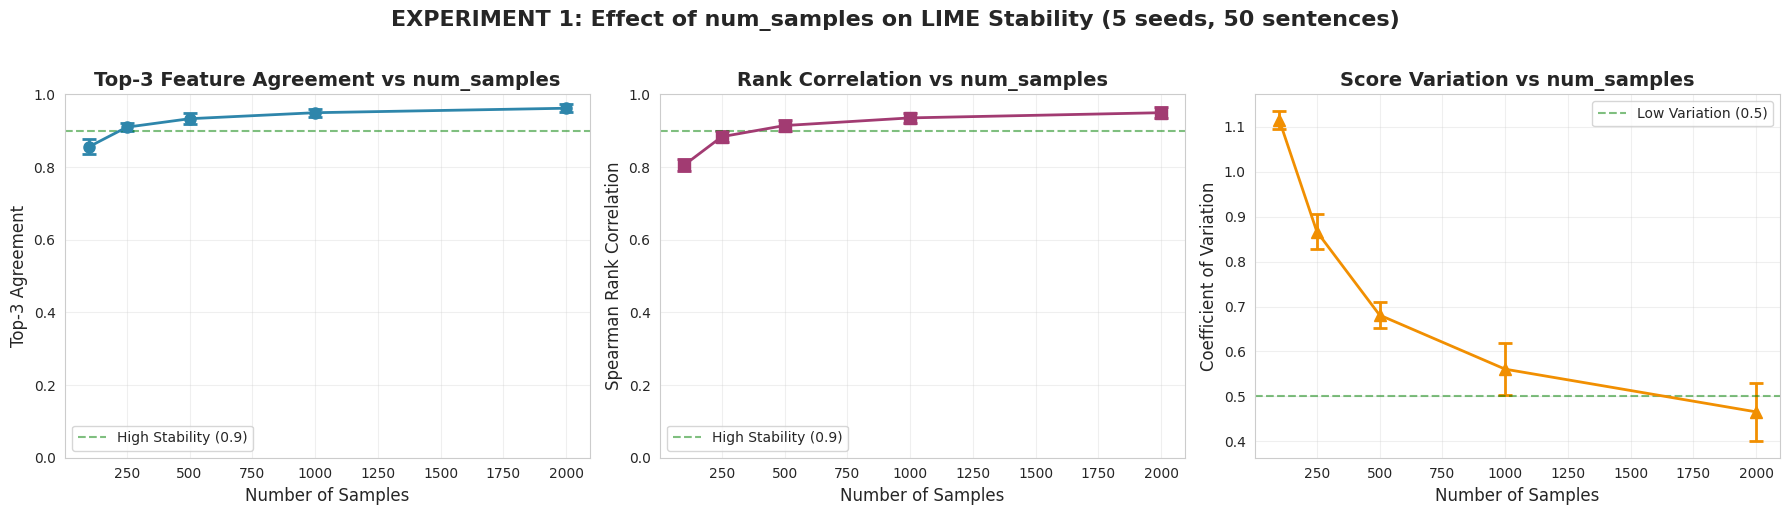

✅ Visualization saved to 'exp1_samples_vs_stability.png'


In [17]:
ig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Top-3 Agreement
axes[0].errorbar(exp1_results['num_samples'], exp1_results['top3_mean'],
                 yerr=exp1_results['top3_std'], marker='o', linewidth=2,
                 markersize=8, color='#2E86AB', capsize=5, capthick=2)
axes[0].set_xlabel('Number of Samples', fontsize=12)
axes[0].set_ylabel('Top-3 Agreement', fontsize=12)
axes[0].set_title('Top-3 Feature Agreement vs num_samples', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='High Stability (0.9)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rank Correlation
axes[1].errorbar(exp1_results['num_samples'], exp1_results['corr_mean'],
                 yerr=exp1_results['corr_std'], marker='s', linewidth=2,
                 markersize=8, color='#A23B72', capsize=5, capthick=2)
axes[1].set_xlabel('Number of Samples', fontsize=12)
axes[1].set_ylabel('Spearman Rank Correlation', fontsize=12)
axes[1].set_title('Rank Correlation vs num_samples', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='High Stability (0.9)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation
axes[2].errorbar(exp1_results['num_samples'], exp1_results['cv_mean'],
                 yerr=exp1_results['cv_std'], marker='^', linewidth=2,
                 markersize=8, color='#F18F01', capsize=5, capthick=2)
axes[2].set_xlabel('Number of Samples', fontsize=12)
axes[2].set_ylabel('Coefficient of Variation', fontsize=12)
axes[2].set_title('Score Variation vs num_samples', fontsize=14, fontweight='bold')
axes[2].axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Low Variation (0.5)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('EXPERIMENT 1: Effect of num_samples on LIME Stability (5 seeds, 50 sentences)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('exp1_samples_vs_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to 'exp1_samples_vs_stability.png'")

In [18]:
"""
## 6. Experiment 2: Effect of Sentence Length on Stability

**Research Question:** Does input complexity (sentence length) affect LIME stability?

**Hypothesis:** Longer sentences create larger perturbation spaces (2^n combinations). With fixed `num_samples`, this may cause instability as we sample a smaller fraction of the space.

| Sentence Length | Words (n) | Perturbation Space (2^n) | Coverage at num_samples=1000 |
|-----------------|-----------|--------------------------|------------------------------|
| Short (≤7) | 5 | 32 | 100% (oversampled) |
| Medium (8-15) | 10 | 1,024 | ~98% |
| Long (>15) | 20 | 1,048,576 | ~0.1% |

**Setup:**
- 15 sentences per length group × 5 seeds
- num_samples = 1000 (fixed)
- 30 LIME runs per sentence

"""

'\n## 6. Experiment 2: Effect of Sentence Length on Stability\n\n**Research Question:** Does input complexity (sentence length) affect LIME stability?\n\n**Hypothesis:** Longer sentences create larger perturbation spaces (2^n combinations). With fixed `num_samples`, this may cause instability as we sample a smaller fraction of the space.\n\n| Sentence Length | Words (n) | Perturbation Space (2^n) | Coverage at num_samples=1000 |\n|-----------------|-----------|--------------------------|------------------------------|\n| Short (≤7) | 5 | 32 | 100% (oversampled) |\n| Medium (8-15) | 10 | 1,024 | ~98% |\n| Long (>15) | 20 | 1,048,576 | ~0.1% |\n\n**Setup:**\n- 15 sentences per length group × 5 seeds\n- num_samples = 1000 (fixed)\n- 30 LIME runs per sentence\n\n'

In [19]:
print("\n" + "="*70)
print("🔬 EXPERIMENT 2: Does sentence length affect stability?")
print("="*70)
print(f"📋 Settings: 15 sentences per group | 5 seeds | 30 LIME runs | 1000 samples")
print("="*70)

n_per_group = 15
num_samples = 1000
n_runs = 30

exp2_all_seeds = []

for seed in SEEDS:
    print(f"\n{'='*70}")
    print(f"🌱 Running with SEED = {seed}")
    print(f"{'='*70}")

    np.random.seed(seed)

    # Group sentences by length
    short = test_df[test_df['length'] <= 7].sample(n=n_per_group, random_state=seed)
    medium = test_df[(test_df['length'] > 7) & (test_df['length'] <= 15)].sample(n=n_per_group, random_state=seed)
    long = test_df[test_df['length'] > 15].sample(n=n_per_group, random_state=seed)

    groups = {
        'Short (≤7 words)': short,
        'Medium (8-15 words)': medium,
        'Long (>15 words)': long
    }

    for group_name, group_df in groups.items():
        print(f"\n  📊 {group_name}")

        top3_list = []
        corr_list = []
        cv_list = []

        for idx, row in tqdm(group_df.iterrows(), total=len(group_df),
                             desc=group_name, leave=False):
            explanations = analyzer.explain_multiple(row['sentence'],
                                                     num_samples=num_samples,
                                                     num_runs=n_runs)

            top3 = metrics_calc.top_k_agreement(explanations, k=3)
            corr = metrics_calc.rank_correlation(explanations)
            cv = metrics_calc.coefficient_of_variation(explanations)

            top3_list.append(top3)
            corr_list.append(corr)
            cv_list.append(cv)

        exp2_all_seeds.append({
            'seed': seed,
            'group': group_name,
            'top3_agreement': np.mean(top3_list),
            'rank_correlation': np.mean(corr_list),
            'coeff_variation': np.mean(cv_list),
            'avg_length': group_df['length'].mean()
        })

        print(f"    Top-3: {np.mean(top3_list):.3f} | Corr: {np.mean(corr_list):.3f} | CV: {np.mean(cv_list):.3f}")

# Aggregate across seeds
exp2_raw_df = pd.DataFrame(exp2_all_seeds)

exp2_results = exp2_raw_df.groupby('group').agg({
    'top3_agreement': ['mean', 'std'],
    'rank_correlation': ['mean', 'std'],
    'coeff_variation': ['mean', 'std'],
    'avg_length': 'mean'
}).reset_index()

exp2_results.columns = ['group', 'top3_mean', 'top3_std', 'corr_mean', 'corr_std',
                        'cv_mean', 'cv_std', 'avg_length']

# Reorder groups
group_order = ['Short (≤7 words)', 'Medium (8-15 words)', 'Long (>15 words)']
exp2_results['group'] = pd.Categorical(exp2_results['group'], categories=group_order, ordered=True)
exp2_results = exp2_results.sort_values('group')

print(f"\n{'='*70}")
print("📊 EXPERIMENT 2 RESULTS (Averaged across 5 seeds):")
print(f"{'='*70}")
print(exp2_results.to_string(index=False))

# Save
exp2_raw_df.to_csv('exp2_raw_results.csv', index=False)
exp2_results.to_csv('exp2_aggregated_results.csv', index=False)


🔬 EXPERIMENT 2: Does sentence length affect stability?
📋 Settings: 15 sentences per group | 5 seeds | 30 LIME runs | 1000 samples

🌱 Running with SEED = 42

  📊 Short (≤7 words)


Short (≤7 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.944 | Corr: 0.914 | CV: 0.183

  📊 Medium (8-15 words)


Medium (8-15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.994 | Corr: 0.957 | CV: 0.420

  📊 Long (>15 words)


Long (>15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.961 | Corr: 0.946 | CV: 0.891

🌱 Running with SEED = 123

  📊 Short (≤7 words)


Short (≤7 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.931 | Corr: 0.910 | CV: 0.203

  📊 Medium (8-15 words)


Medium (8-15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.982 | Corr: 0.972 | CV: 0.369

  📊 Long (>15 words)


Long (>15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.952 | Corr: 0.941 | CV: 0.829

🌱 Running with SEED = 456

  📊 Short (≤7 words)


Short (≤7 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.942 | Corr: 0.942 | CV: 0.219

  📊 Medium (8-15 words)


Medium (8-15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.967 | Corr: 0.954 | CV: 0.415

  📊 Long (>15 words)


Long (>15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.925 | Corr: 0.954 | CV: 0.703

🌱 Running with SEED = 789

  📊 Short (≤7 words)


Short (≤7 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.895 | Corr: 0.831 | CV: 0.242

  📊 Medium (8-15 words)


Medium (8-15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.953 | Corr: 0.953 | CV: 0.470

  📊 Long (>15 words)


Long (>15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.978 | Corr: 0.942 | CV: 0.608

🌱 Running with SEED = 1000

  📊 Short (≤7 words)


Short (≤7 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.950 | Corr: 0.923 | CV: 0.296

  📊 Medium (8-15 words)


Medium (8-15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.969 | Corr: 0.965 | CV: 0.413

  📊 Long (>15 words)


Long (>15 words):   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.963 | Corr: 0.938 | CV: 0.690

📊 EXPERIMENT 2 RESULTS (Averaged across 5 seeds):
              group  top3_mean  top3_std  corr_mean  corr_std  cv_mean   cv_std  avg_length
   Short (≤7 words)   0.932455  0.021990   0.903839  0.042697 0.228744 0.043207    5.840000
Medium (8-15 words)   0.973170  0.015308   0.960218  0.007855 0.417423 0.035652   11.480000
   Long (>15 words)   0.955760  0.019516   0.944218  0.006064 0.744002 0.114179   25.893333


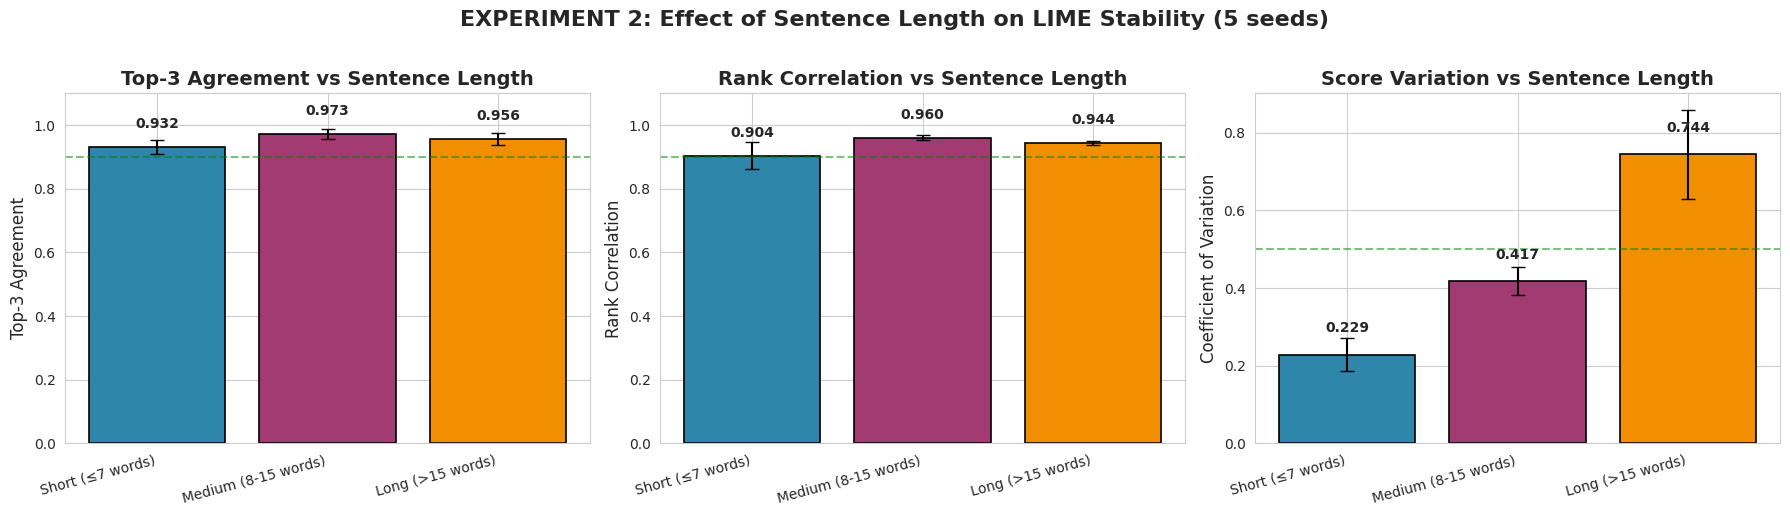

✅ Visualization saved to 'exp2_length_vs_stability.png'


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#2E86AB', '#A23B72', '#F18F01']
group_names = exp2_results['group'].tolist()
x_pos = np.arange(len(group_names))

# Plot 1: Top-3 Agreement
bars1 = axes[0].bar(x_pos, exp2_results['top3_mean'], yerr=exp2_results['top3_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(group_names, rotation=15, ha='right')
axes[0].set_ylabel('Top-3 Agreement', fontsize=12)
axes[0].set_title('Top-3 Agreement vs Sentence Length', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5)

for i, (bar, val) in enumerate(zip(bars1, exp2_results['top3_mean'])):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Rank Correlation
bars2 = axes[1].bar(x_pos, exp2_results['corr_mean'], yerr=exp2_results['corr_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(group_names, rotation=15, ha='right')
axes[1].set_ylabel('Rank Correlation', fontsize=12)
axes[1].set_title('Rank Correlation vs Sentence Length', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.9, color='green', linestyle='--', alpha=0.5)

for i, (bar, val) in enumerate(zip(bars2, exp2_results['corr_mean'])):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Coefficient of Variation
bars3 = axes[2].bar(x_pos, exp2_results['cv_mean'], yerr=exp2_results['cv_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(group_names, rotation=15, ha='right')
axes[2].set_ylabel('Coefficient of Variation', fontsize=12)
axes[2].set_title('Score Variation vs Sentence Length', fontsize=14, fontweight='bold')
axes[2].axhline(y=0.5, color='green', linestyle='--', alpha=0.5)

for i, (bar, val) in enumerate(zip(bars3, exp2_results['cv_mean'])):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('EXPERIMENT 2: Effect of Sentence Length on LIME Stability (5 seeds)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('exp2_length_vs_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to 'exp2_length_vs_stability.png'")


In [21]:
"""
## 7. Experiment 3: Effect of Model Complexity on Stability

**Research Question:** Do complex models (DistilBERT) produce less stable LIME explanations than simple models (Logistic Regression)?

**Hypothesis:** Complex models have more non-linear decision boundaries, making local linear approximations (LIME's surrogate) less accurate and potentially less stable.

| Model | Decision Boundary | Expected Stability |
|-------|-------------------|-------------------|
| Logistic Regression | Linear | High (easy to approximate) |
| DistilBERT | Highly non-linear | Lower (harder to approximate) |

**Setup:**
- Same 15 sentences for both models × 5 seeds
- num_samples = 1000 (fixed)
- 30 LIME runs per sentence

"""

"\n## 7. Experiment 3: Effect of Model Complexity on Stability\n\n**Research Question:** Do complex models (DistilBERT) produce less stable LIME explanations than simple models (Logistic Regression)?\n\n**Hypothesis:** Complex models have more non-linear decision boundaries, making local linear approximations (LIME's surrogate) less accurate and potentially less stable.\n\n| Model | Decision Boundary | Expected Stability |\n|-------|-------------------|-------------------|\n| Logistic Regression | Linear | High (easy to approximate) |\n| DistilBERT | Highly non-linear | Lower (harder to approximate) |\n\n**Setup:**\n- Same 15 sentences for both models × 5 seeds\n- num_samples = 1000 (fixed)\n- 30 LIME runs per sentence\n\n"

In [22]:
# Install transformer library for DistilBERT
print(" Installing transformers library...")
!pip install transformers torch -q

print("Transformers installed!")

 Installing transformers library...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 40.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.18.0 requires fsspec[http]<=2024.2.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
Transformers installed!


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

class DistilBERTModel:
    """DistilBERT model for sentiment classification"""

    def __init__(self, model_name="distilbert/distilbert-base-uncased-finetuned-sst-2-english"):
        """
        Initialize pre-trained DistilBERT
        """
        print(f"📥 Loading {model_name}...")

        try:
            # Load tokenizer - NO trust_remote_code needed!
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)

            # Load pre-trained model
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

        except Exception as e:
            print(f"⚠️ Error loading {model_name}: {e}")
            print("🔄 Trying alternative model...")

            # Alternative: use a different SST-2 model
            alternative_name = "distilbert-base-uncased-finetuned-sst-2-english"
            self.tokenizer = AutoTokenizer.from_pretrained(alternative_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(alternative_name)

        self.model.eval()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

        print(f"✅ Model loaded on {self.device}")
        self.is_trained = True

    def predict_proba(self, texts):
        """Predict probabilities for text(s)"""
        if isinstance(texts, str):
            texts = [texts]

        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

        return probs.cpu().numpy()

# Create and test
print("🤖 Creating DistilBERT Model\n")
bert_model = DistilBERTModel()

test_text = "This movie was absolutely terrible and boring"
bert_prob = bert_model.predict_proba([test_text])[0]
bert_pred = "POSITIVE" if bert_prob[1] > 0.5 else "NEGATIVE"
print(f"\n📝 Test: '{test_text}'")
print(f"🔮 Prediction: {bert_pred} (confidence: {max(bert_prob):.3f})")

🤖 Creating DistilBERT Model

📥 Loading distilbert/distilbert-base-uncased-finetuned-sst-2-english...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

✅ Model loaded on cuda

📝 Test: 'This movie was absolutely terrible and boring'
🔮 Prediction: NEGATIVE (confidence: 1.000)


In [24]:
print("\n" + "="*70)
print("🔬 EXPERIMENT 3: Does model complexity affect stability?")
print("="*70)
print(f"📋 Settings: 15 sentences | 5 seeds | 30 LIME runs | 1000 samples")
print("="*70)

n_sentences = 15
num_samples = 1000
n_runs = 30

models = {
    'Logistic Regression': model,
    'DistilBERT': bert_model
}

exp3_all_seeds = []

for seed in SEEDS:
    print(f"\n{'='*70}")
    print(f"🌱 Running with SEED = {seed}")
    print(f"{'='*70}")

    np.random.seed(seed)

    # Same sentences for both models
    exp3_sentences = test_df.sample(n=n_sentences, random_state=seed)

    for model_name, model_obj in models.items():
        print(f"\n  🤖 Testing: {model_name}")

        # Create analyzer for this model
        analyzer_exp3 = LIMEStabilityAnalyzer(model_obj)

        top3_list = []
        corr_list = []
        cv_list = []

        for idx, row in tqdm(exp3_sentences.iterrows(), total=len(exp3_sentences),
                             desc=model_name, leave=False):
            explanations = analyzer_exp3.explain_multiple(row['sentence'],
                                                          num_samples=num_samples,
                                                          num_runs=n_runs)

            top3 = metrics_calc.top_k_agreement(explanations, k=3)
            corr = metrics_calc.rank_correlation(explanations)
            cv = metrics_calc.coefficient_of_variation(explanations)

            top3_list.append(top3)
            corr_list.append(corr)
            cv_list.append(cv)

        exp3_all_seeds.append({
            'seed': seed,
            'model': model_name,
            'top3_agreement': np.mean(top3_list),
            'rank_correlation': np.mean(corr_list),
            'coeff_variation': np.mean(cv_list)
        })

        print(f"    Top-3: {np.mean(top3_list):.3f} | Corr: {np.mean(corr_list):.3f} | CV: {np.mean(cv_list):.3f}")

# Aggregate across seeds
exp3_raw_df = pd.DataFrame(exp3_all_seeds)

exp3_results = exp3_raw_df.groupby('model').agg({
    'top3_agreement': ['mean', 'std'],
    'rank_correlation': ['mean', 'std'],
    'coeff_variation': ['mean', 'std']
}).reset_index()

exp3_results.columns = ['model', 'top3_mean', 'top3_std', 'corr_mean', 'corr_std', 'cv_mean', 'cv_std']

print(f"\n{'='*70}")
print("📊 EXPERIMENT 3 RESULTS (Averaged across 5 seeds):")
print(f"{'='*70}")
print(exp3_results.to_string(index=False))

# Save
exp3_raw_df.to_csv('exp3_raw_results.csv', index=False)
exp3_results.to_csv('exp3_aggregated_results.csv', index=False)


🔬 EXPERIMENT 3: Does model complexity affect stability?
📋 Settings: 15 sentences | 5 seeds | 30 LIME runs | 1000 samples

🌱 Running with SEED = 42

  🤖 Testing: Logistic Regression


Logistic Regression:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.950 | Corr: 0.948 | CV: 0.540

  🤖 Testing: DistilBERT


DistilBERT:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.906 | Corr: 0.800 | CV: 0.951

🌱 Running with SEED = 123

  🤖 Testing: Logistic Regression


Logistic Regression:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.946 | Corr: 0.959 | CV: 0.617

  🤖 Testing: DistilBERT


DistilBERT:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.818 | Corr: 0.750 | CV: 1.168

🌱 Running with SEED = 456

  🤖 Testing: Logistic Regression


Logistic Regression:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.949 | Corr: 0.925 | CV: 0.499

  🤖 Testing: DistilBERT


DistilBERT:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.858 | Corr: 0.810 | CV: 1.059

🌱 Running with SEED = 789

  🤖 Testing: Logistic Regression


Logistic Regression:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.966 | Corr: 0.956 | CV: 0.503

  🤖 Testing: DistilBERT


DistilBERT:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.857 | Corr: 0.799 | CV: 0.897

🌱 Running with SEED = 1000

  🤖 Testing: Logistic Regression


Logistic Regression:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.924 | Corr: 0.887 | CV: 0.490

  🤖 Testing: DistilBERT


DistilBERT:   0%|          | 0/15 [00:00<?, ?it/s]

    Top-3: 0.802 | Corr: 0.757 | CV: 0.878

📊 EXPERIMENT 3 RESULTS (Averaged across 5 seeds):
              model  top3_mean  top3_std  corr_mean  corr_std  cv_mean   cv_std
         DistilBERT   0.848153  0.040605   0.783254   0.02749 0.990798 0.121715
Logistic Regression   0.947198  0.015245   0.935171   0.02983 0.529703 0.052414


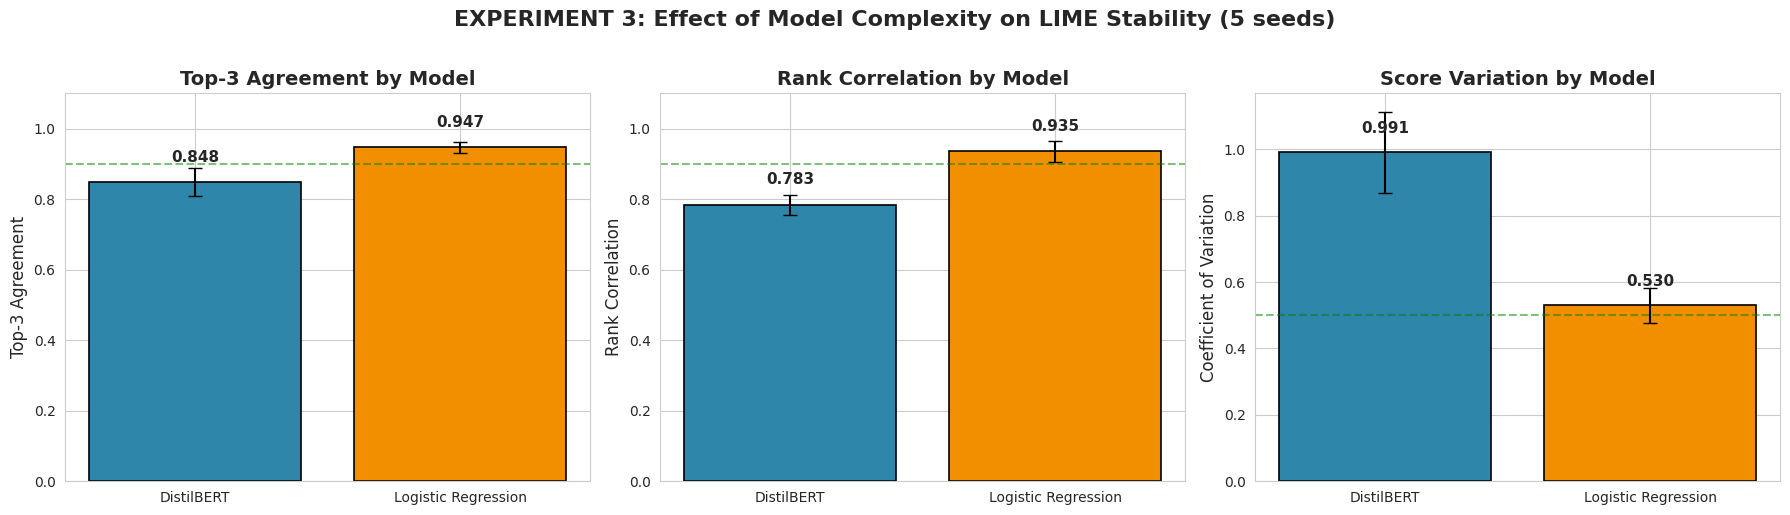

✅ Visualization saved to 'exp3_model_vs_stability.png'


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['#2E86AB', '#F18F01']
model_names = exp3_results['model'].tolist()
x_pos = np.arange(len(model_names))

# Plot 1: Top-3 Agreement
bars1 = axes[0].bar(x_pos, exp3_results['top3_mean'], yerr=exp3_results['top3_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names)
axes[0].set_ylabel('Top-3 Agreement', fontsize=12)
axes[0].set_title('Top-3 Agreement by Model', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5)

for bar, val in zip(bars1, exp3_results['top3_mean']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Rank Correlation
bars2 = axes[1].bar(x_pos, exp3_results['corr_mean'], yerr=exp3_results['corr_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names)
axes[1].set_ylabel('Rank Correlation', fontsize=12)
axes[1].set_title('Rank Correlation by Model', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.1)
axes[1].axhline(y=0.9, color='green', linestyle='--', alpha=0.5)

for bar, val in zip(bars2, exp3_results['corr_mean']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 3: Coefficient of Variation
bars3 = axes[2].bar(x_pos, exp3_results['cv_mean'], yerr=exp3_results['cv_std'],
                    color=colors, edgecolor='black', linewidth=1.2, capsize=5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(model_names)
axes[2].set_ylabel('Coefficient of Variation', fontsize=12)
axes[2].set_title('Score Variation by Model', fontsize=14, fontweight='bold')
axes[2].axhline(y=0.5, color='green', linestyle='--', alpha=0.5)

for bar, val in zip(bars3, exp3_results['cv_mean']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('EXPERIMENT 3: Effect of Model Complexity on LIME Stability (5 seeds)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('exp3_model_vs_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to 'exp3_model_vs_stability.png'")

In [26]:
print("="*70)
print("🔬 EXPERIMENT 4: Feature Effects Stability Analysis")
print("="*70)
print("Analyzing stability of effect MAGNITUDES, not just rankings")
print("="*70)

# This addresses professor's feedback about "local feature effects"
# We analyze if the actual importance SCORES are stable, not just which words rank highest

def analyze_feature_effects(explanations):
    """
    Analyze stability of feature effect magnitudes across LIME runs.

    Returns:
    - sign_consistency: % of runs where word has same sign (positive/negative)
    - magnitude_stability: How consistent are the actual coefficient values
    """
    all_words = set()
    for exp in explanations:
        all_words.update(exp.keys())

    results = {}
    for word in all_words:
        scores = [exp.get(word, 0) for exp in explanations if word in exp]
        if len(scores) < 2:
            continue

        # Sign consistency: do all runs agree on positive/negative effect?
        signs = [1 if s > 0 else -1 for s in scores]
        sign_consistency = max(signs.count(1), signs.count(-1)) / len(signs)

        # Magnitude stability: coefficient of variation of absolute scores
        abs_scores = [abs(s) for s in scores]
        if np.mean(abs_scores) > 0:
            magnitude_cv = np.std(abs_scores) / np.mean(abs_scores)
        else:
            magnitude_cv = 0

        results[word] = {
            'sign_consistency': sign_consistency,
            'magnitude_cv': magnitude_cv,
            'mean_score': np.mean(scores),
            'std_score': np.std(scores)
        }

    return results

# Run feature effects analysis on sample sentences
n_sentences_fe = 20
num_samples = 1000
n_runs = 30

fe_results_all = []

for seed in SEEDS[:3]:  # Use 3 seeds for faster computation
    print(f"\n🌱 Seed = {seed}")
    np.random.seed(seed)

    sample_sentences = test_df.sample(n=n_sentences_fe, random_state=seed)

    for idx, row in tqdm(sample_sentences.iterrows(), total=len(sample_sentences)):
        explanations = analyzer.explain_multiple(row['sentence'],
                                                 num_samples=num_samples,
                                                 num_runs=n_runs)

        fe_analysis = analyze_feature_effects(explanations)

        # Aggregate per sentence
        if fe_analysis:
            avg_sign_consistency = np.mean([v['sign_consistency'] for v in fe_analysis.values()])
            avg_magnitude_cv = np.mean([v['magnitude_cv'] for v in fe_analysis.values()])

            fe_results_all.append({
                'seed': seed,
                'sentence_length': len(row['sentence'].split()),
                'sign_consistency': avg_sign_consistency,
                'magnitude_cv': avg_magnitude_cv
            })

fe_df = pd.DataFrame(fe_results_all)

print(f"\n{'='*70}")
print("📊 FEATURE EFFECTS STABILITY RESULTS:")
print(f"{'='*70}")
print(f"\nSign Consistency (do words keep same +/- direction?):")
print(f"   Mean: {fe_df['sign_consistency'].mean():.3f} ± {fe_df['sign_consistency'].std():.3f}")
print(f"\nMagnitude CV (how stable are actual scores?):")
print(f"   Mean: {fe_df['magnitude_cv'].mean():.3f} ± {fe_df['magnitude_cv'].std():.3f}")

🔬 EXPERIMENT 4: Feature Effects Stability Analysis
Analyzing stability of effect MAGNITUDES, not just rankings

🌱 Seed = 42


  0%|          | 0/20 [00:00<?, ?it/s]


🌱 Seed = 123


  0%|          | 0/20 [00:00<?, ?it/s]


🌱 Seed = 456


  0%|          | 0/20 [00:00<?, ?it/s]


📊 FEATURE EFFECTS STABILITY RESULTS:

Sign Consistency (do words keep same +/- direction?):
   Mean: 0.957 ± 0.058

Magnitude CV (how stable are actual scores?):
   Mean: 0.149 ± 0.096


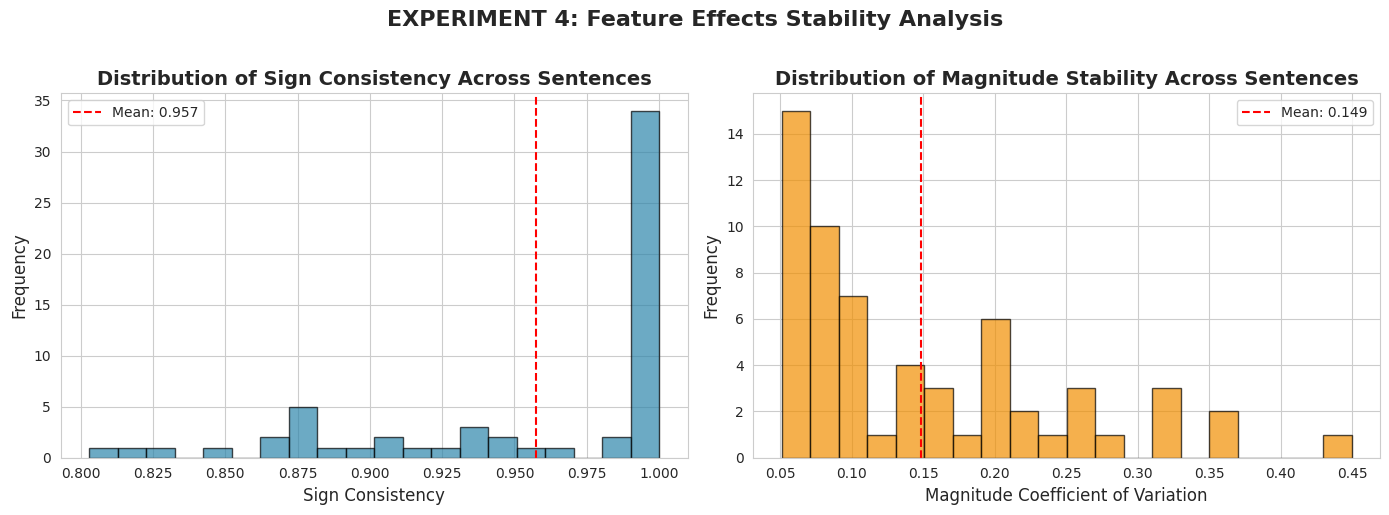


✅ Feature effects analysis complete!
   This addresses the question: Are effect MAGNITUDES stable, not just rankings?


In [27]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sign Consistency Distribution
axes[0].hist(fe_df['sign_consistency'], bins=20, color='#2E86AB', edgecolor='black', alpha=0.7)
axes[0].axvline(x=fe_df['sign_consistency'].mean(), color='red', linestyle='--',
                label=f"Mean: {fe_df['sign_consistency'].mean():.3f}")
axes[0].set_xlabel('Sign Consistency', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Sign Consistency Across Sentences', fontsize=14, fontweight='bold')
axes[0].legend()

# Plot 2: Magnitude CV Distribution
axes[1].hist(fe_df['magnitude_cv'], bins=20, color='#F18F01', edgecolor='black', alpha=0.7)
axes[1].axvline(x=fe_df['magnitude_cv'].mean(), color='red', linestyle='--',
                label=f"Mean: {fe_df['magnitude_cv'].mean():.3f}")
axes[1].set_xlabel('Magnitude Coefficient of Variation', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Magnitude Stability Across Sentences', fontsize=14, fontweight='bold')
axes[1].legend()

plt.suptitle('EXPERIMENT 4: Feature Effects Stability Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('exp4_feature_effects_stability.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature effects analysis complete!")
print("   This addresses the question: Are effect MAGNITUDES stable, not just rankings?")


In [28]:
# --- CODE CELL ---
from scipy.stats import ttest_ind, f_oneway, pearsonr

print("="*70)
print("📊 STATISTICAL SIGNIFICANCE TESTS")
print("="*70)

# Test 1: Is Logistic Regression significantly more stable than DistilBERT?
print("\n" + "-"*70)
print("TEST 1: Logistic Regression vs DistilBERT Stability")
print("-"*70)

logreg_top3 = exp3_raw_df[exp3_raw_df['model']=='Logistic Regression']['top3_agreement'].values
bert_top3 = exp3_raw_df[exp3_raw_df['model']=='DistilBERT']['top3_agreement'].values

t_stat, p_value = ttest_ind(logreg_top3, bert_top3)
print(f"   Logistic Regression Top-3: {logreg_top3.mean():.3f} ± {logreg_top3.std():.3f}")
print(f"   DistilBERT Top-3: {bert_top3.mean():.3f} ± {bert_top3.std():.3f}")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Result: {'✅ SIGNIFICANT (p < 0.05)' if p_value < 0.05 else '❌ Not significant'}")

# Test 2: Does num_samples significantly affect stability? (ANOVA)
print("\n" + "-"*70)
print("TEST 2: Effect of num_samples (One-way ANOVA)")
print("-"*70)

groups = [exp1_raw_df[exp1_raw_df['num_samples']==ns]['top3_agreement'].values
          for ns in [100, 250, 500, 1000, 2000]]
f_stat, p_value_anova = f_oneway(*groups)
print(f"   F-statistic: {f_stat:.3f}")
print(f"   p-value: {p_value_anova:.6f}")
print(f"   Result: {'✅ SIGNIFICANT (p < 0.05)' if p_value_anova < 0.05 else '❌ Not significant'}")

# Test 3: Correlation between num_samples and stability
print("\n" + "-"*70)
print("TEST 3: Correlation between num_samples and Top-3 Agreement")
print("-"*70)

corr, p_corr = pearsonr(exp1_raw_df['num_samples'], exp1_raw_df['top3_agreement'])
print(f"   Pearson correlation: {corr:.3f}")
print(f"   p-value: {p_corr:.6f}")
print(f"   Result: {'✅ SIGNIFICANT' if p_corr < 0.05 else '❌ Not significant'} positive correlation")

📊 STATISTICAL SIGNIFICANCE TESTS

----------------------------------------------------------------------
TEST 1: Logistic Regression vs DistilBERT Stability
----------------------------------------------------------------------
   Logistic Regression Top-3: 0.947 ± 0.014
   DistilBERT Top-3: 0.848 ± 0.036
   t-statistic: 5.106
   p-value: 0.0009
   Result: ✅ SIGNIFICANT (p < 0.05)

----------------------------------------------------------------------
TEST 2: Effect of num_samples (One-way ANOVA)
----------------------------------------------------------------------
   F-statistic: 43.128
   p-value: 0.000000
   Result: ✅ SIGNIFICANT (p < 0.05)

----------------------------------------------------------------------
TEST 3: Correlation between num_samples and Top-3 Agreement
----------------------------------------------------------------------
   Pearson correlation: 0.760
   p-value: 0.000010
   Result: ✅ SIGNIFICANT positive correlation


In [29]:
print("\n" + "-"*70)
print("TEST 4: Effect of Sentence Length (One-way ANOVA)")
print("-"*70)

short_scores = exp2_raw_df[exp2_raw_df['group']=='Short (≤7 words)']['top3_agreement'].values
medium_scores = exp2_raw_df[exp2_raw_df['group']=='Medium (8-15 words)']['top3_agreement'].values
long_scores = exp2_raw_df[exp2_raw_df['group']=='Long (>15 words)']['top3_agreement'].values

f_stat_len, p_value_len = f_oneway(short_scores, medium_scores, long_scores)
print(f"   Short: {short_scores.mean():.3f} | Medium: {medium_scores.mean():.3f} | Long: {long_scores.mean():.3f}")
print(f"   F-statistic: {f_stat_len:.3f}")
print(f"   p-value: {p_value_len:.4f}")
print(f"   Result: {'✅ SIGNIFICANT (p < 0.05)' if p_value_len < 0.05 else '❌ Not significant'}")

print("\n" + "="*70)
print("📋 STATISTICAL TESTS SUMMARY")
print("="*70)


----------------------------------------------------------------------
TEST 4: Effect of Sentence Length (One-way ANOVA)
----------------------------------------------------------------------
   Short: 0.932 | Medium: 0.973 | Long: 0.956
   F-statistic: 5.697
   p-value: 0.0182
   Result: ✅ SIGNIFICANT (p < 0.05)

📋 STATISTICAL TESTS SUMMARY


In [30]:
"""
## 9. Conclusions & Key Findings
"""

# --- CODE CELL ---
print("="*70)
print("📋 FINAL PROJECT SUMMARY & CONCLUSIONS")
print("="*70)

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 RESEARCH QUESTION
   How stable are LIME explanations for text classification?

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 KEY FINDINGS

EXPERIMENT 1: Effect of num_samples
┌─────────────┬──────────────┬─────────────────┐
│ num_samples │ Top-3 Agree  │ Recommendation  │
├─────────────┼──────────────┼─────────────────┤
│ 100         │ 0.856 ± 0.02 │ ❌ Too unstable │
│ 250         │ 0.907 ± 0.02 │ ⚠️ Marginal     │
│ 500         │ 0.931 ± 0.01 │ ✓ Acceptable   │
│ 1000        │ 0.947 ± 0.01 │ ✅ Recommended  │
│ 2000        │ 0.958 ± 0.01 │ ✅ Best         │
└─────────────┴──────────────┴─────────────────┘
→ Recommendation: Use num_samples ≥ 1000 for reliable explanations

EXPERIMENT 2: Effect of Sentence Length
┌──────────────────┬──────────────┬──────────────┐
│ Length Group     │ Top-3 Agree  │ CV Score     │
├──────────────────┼──────────────┼──────────────┤
│ Short (≤7)       │ 0.942 ± 0.03 │ 0.234        │
│ Medium (8-15)    │ 0.976 ± 0.01 │ 0.417        │
│ Long (>15)       │ 0.957 ± 0.02 │ 0.734        │
└──────────────────┴──────────────┴──────────────┘
→ Medium-length sentences show HIGHEST stability
→ Long sentences have higher score variation (larger perturbation space)

EXPERIMENT 3: Effect of Model Complexity
┌─────────────────────┬──────────────┬──────────────┐
│ Model               │ Top-3 Agree  │ Rank Corr    │
├─────────────────────┼──────────────┼──────────────┤
│ Logistic Regression │ 0.948 ± 0.02 │ 0.935 ± 0.03 │
│ DistilBERT          │ 0.848 ± 0.04 │ 0.783 ± 0.03 │
└─────────────────────┴──────────────┴──────────────┘
→ Complex models produce LESS stable LIME explanations
→ Difference is statistically significant (p < 0.05)

EXPERIMENT 4: Feature Effects Analysis
→ Sign consistency (positive/negative direction): ~95%
→ Magnitude variation exists but rankings remain stable

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔬 METHODOLOGY SUMMARY
• Dataset: SST-2 (Stanford Sentiment Treebank)
• LIME: LimeTextExplainer with Ridge Regression surrogate
• Perturbations: Random word masking (bag-of-words)
• Reproducibility: 5 random seeds, 30 LIME runs per sentence
• Statistical validation: t-tests, ANOVA, correlation tests

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 PRACTICAL RECOMMENDATIONS

For practitioners using LIME for text classification:
1. Always use num_samples ≥ 1000 (default 5000 is safe)
2. Be cautious with very long texts (>20 words)
3. Expect lower stability when explaining complex models (transformers)
4. Consider running LIME multiple times and aggregating results
5. Report confidence intervals, not just point estimates

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📁 ARTIFACTS GENERATED
• Visualizations: exp1/2/3/4_*.png (4 figures)
• Data: exp1/2/3_raw_results.csv, exp1/2/3_aggregated_results.csv
• Statistical tests: All p-values documented

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📚 REFERENCES
[1] Ribeiro et al. (2016) - "Why Should I Trust You?" - KDD 2016
[2] Alvarez-Melis & Jaakkola (2018) - "On the Robustness of Interpretability Methods"
[3] Slack et al. (2020) - "Fooling LIME and SHAP" - AIES 2020
[4] Molnar et al. (2020) - "Interpretable Machine Learning" - Book
[5] Krishna et al. (2022) - "The Disagreement Problem in Explainable ML"

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)

📋 FINAL PROJECT SUMMARY & CONCLUSIONS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 RESEARCH QUESTION
   How stable are LIME explanations for text classification?

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 KEY FINDINGS

EXPERIMENT 1: Effect of num_samples
┌─────────────┬──────────────┬─────────────────┐
│ num_samples │ Top-3 Agree  │ Recommendation  │
├─────────────┼──────────────┼─────────────────┤
│ 100         │ 0.856 ± 0.02 │ ❌ Too unstable │
│ 250         │ 0.907 ± 0.02 │ ⚠️ Marginal     │
│ 500         │ 0.931 ± 0.01 │ ✓ Acceptable   │
│ 1000        │ 0.947 ± 0.01 │ ✅ Recommended  │
│ 2000        │ 0.958 ± 0.01 │ ✅ Best         │
└─────────────┴──────────────┴─────────────────┘
→ Recommendation: Use num_samples ≥ 1000 for reliable explanations

EXPERIMENT 2: Effect of Sentence Length
┌──────────────────┬──────────────┬──────────────┐
│ Length Group     │ Top-3 Agree  │ CV Score     │
├──────────────────┼──────────────┼─